In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import sklearn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [5]:
import skimage.io as io
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter

/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [6]:
trkp_files = []
trkn_files = []
emcal_files = []
hcal_files = []
truth_files = []

In [7]:
directory = "/Users/jenson/Downloads/Gauss_S1.00_NL0.30_B0.50"

for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    
    if "trkp" in file_path:
        trkp_files.append(file_path)
    elif "trkn" in file_path:
        trkn_files.append(file_path)
    elif "emcal" in file_path:
        emcal_files.append(file_path)
    elif "hcal" in file_path:
        hcal_files.append(file_path)
    elif "truth" in file_path:
        truth_files.append(file_path)

In [8]:
def key(s):
    matches = re.findall(r'\d+', s)
    return int(matches[-1]) if matches else float('inf')


trkp_files = sorted(trkp_files, key = key)
trkn_files = sorted(trkn_files, key = key)
emcal_files = sorted(emcal_files, key = key)
hcal_files = sorted(hcal_files, key = key)
truth_files = sorted(truth_files, key = key)



short_trkp_files = trkp_files[:2000]
short_trkn_files = trkn_files[:2000]
short_emcal_files = emcal_files[:2000]
short_hcal_files = hcal_files[:2000]
short_truth_files = truth_files[:2000]

In [9]:
trkp_data = np.array(list(map(io.imread, short_trkp_files)))
trkn_data = np.array(list(map(io.imread, short_trkn_files)))
emcal_data = np.array(list(map(io.imread, short_emcal_files)))
hcal_data = np.array(list(map(io.imread, short_hcal_files)))
truth_data = np.array(list(map(io.imread, short_truth_files)))


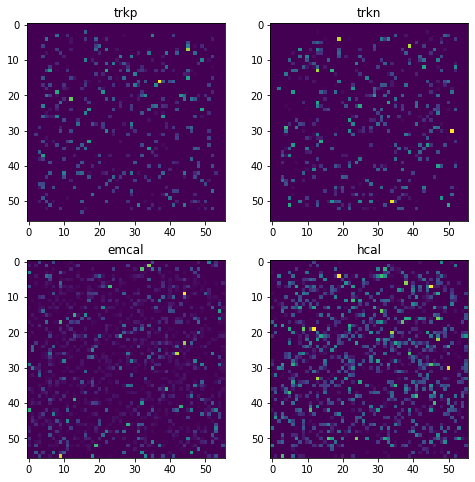

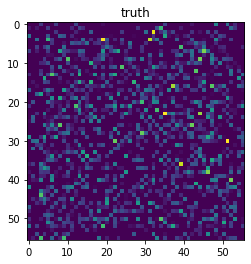

In [10]:
fig = plt.figure(figsize = (8,8))
plt.subplot(2,2,1)
plt.imshow(trkp_data[0])
plt.title("trkp")

plt.subplot(2,2,2)
plt.imshow(trkn_data[0])
plt.title("trkn")

plt.subplot(2,2,3)
plt.imshow(emcal_data[0])
plt.title("emcal")

plt.subplot(2,2,4)
plt.imshow(hcal_data[0])
plt.title("hcal")
plt.show()


plt.imshow(truth_data[0])
plt.title("truth")
plt.show()


In [11]:
X = np.array(list(zip(trkp_data,
        trkn_data,
        emcal_data,
        hcal_data)))

y = truth_data


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)


train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size = 100, shuffle = False)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size = 100, shuffle = False)

# Nested U-net model with jumping connections

In [12]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(VGGBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

In [13]:
class Nested_U_net(nn.Module):
    def __init__(self, in_channels, out_channels, deep_supervision = False):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.deep_supervision = deep_supervision
        #encoder path (col0)
        self.conv_0_0 = VGGBlock(in_channels, 8, 8)
        self.conv_1_0 = VGGBlock(8, 16, 16)
        self.conv_2_0 = VGGBlock(16, 32, 32)
        self.conv_3_0 = VGGBlock(32, 64, 64)
        
        #col 1
        self.conv_0_1 = VGGBlock(24, 32, 32)
        self.conv_1_1 = VGGBlock(48, 32, 32)
        self.conv_2_1 = VGGBlock(96, 16, 16)
        
        
        #col 2
        self.conv_0_2 = VGGBlock(8+32+32 ,16, 16)
        self.conv_1_2 = VGGBlock(32+16+16, 8, 8)
        
        #col 3
        self.conv_0_3 = VGGBlock(8+32+16+8, 8, 8)
        
        
        
        #outputs
        self.final_0_1 = nn.Conv2d(32, out_channels, kernel_size=3, stride=1, padding=1)
        self.final_0_2 = nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1)
        self.final_0_3 = nn.Conv2d(8, out_channels, kernel_size=3, stride=1, padding=1)
       
    def forward(self, x):
        x_0_0 = self.conv_0_0(x)
        x_1_0 = self.conv_1_0(self.pool(x_0_0))
        x_0_1 = self.conv_0_1(torch.cat([x_0_0,self.up(x_1_0)], dim = 1))
        
        x_2_0 = self.conv_2_0(self.pool(x_1_0))
        x_1_1 = self.conv_1_1(torch.cat([x_1_0, self.up(x_2_0)], dim = 1))
        x_0_2 = self.conv_0_2(torch.cat([x_0_1, self.up(x_1_1), x_0_0], dim = 1))
        
        x_3_0 = self.conv_3_0(self.pool(x_2_0))
        x_2_1 = self.conv_2_1(torch.cat([x_2_0, self.up(x_3_0)], dim = 1))
        x_1_2 = self.conv_1_2(torch.cat([x_1_1, self.up(x_2_1), x_1_0], dim = 1))
        x_0_3 = self.conv_0_3(torch.cat([x_0_2, self.up(x_1_2), x_0_0, x_0_1], dim = 1))
        
       
        if self.deep_supervision:
            return [self.final_0_1(x_0_1),
                    self.final_0_2(x_0_2),
                    self.final_0_3(x_0_3)]
            
        else:
            
            return [self.final_0_3(x_0_3)]
        

In [14]:
class Output_processor0(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(56*56*3, 56*56)
        self.relu = nn.ReLU()
                                  
        self.apply(self.custom_weights_init)
        
        
    def custom_weights_init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.constant_(m.weight, 0.33333333)
            
            
            nn.init.constant_(m.bias, 0) 

        
    def forward(self,x):
        x = x.view(1, -1)
        x = self.l1(x)
        x = self.relu(x)
        return x
    
    
    
    

In [15]:
class Output_processor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=1, stride=1, padding=0, bias=False)
        
        # Set the weights to average the input images
        with torch.no_grad():
            # Each input channel should contribute equally, so set weights to 1/3
            self.conv.weight.data.fill_(1/3)

    def forward(self, x):
        return self.conv(x)

In [16]:
model = Nested_U_net(4, 1)
model(torch.randn(1, 4, 56, 56))[-1].size()

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 1, 56, 56])

In [17]:
processor = Output_processor()
processor(torch.randn(3, 56,56)).size()

torch.Size([1, 56, 56])

#  model training

In [18]:
def lr_decay(epochs):
    pass

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
network = Nested_U_net(4, 1, deep_supervision = True).to(device)
loss_func = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(network.parameters(), lr = 0.001)

cpu


In [20]:
from tqdm import tqdm

In [21]:
output_loss_1 = []
output_loss_2 = []
output_loss_3 = []


In [22]:
#如果效果不好把 deep_supervision 设为 False!!
for epoch in range(250):
    for count, (data, mask) in enumerate(tqdm(train_loader)):
        mask = mask.resize(data.size(0), 1, 56, 56)   
        optimizer.zero_grad()
        out = network(data)
        if getattr(network, "deep_supervision"):
            tot_loss = sum([loss_func(i, mask) for i in out])
            loss1 = loss_func(out[0], mask)
            loss2 = loss_func(out[1], mask)
            loss3 = loss_func(out[2], mask)
        else:
            tot_loss = loss_func(out[-1], mask)
            loss1, loss2, loss3 = None, None, None
            
        if (loss1, loss2, loss3) != (None, None, None):
            output_loss_1.append(loss1.item())
            output_loss_2.append(loss2.item())
            output_loss_3.append(loss3.item())
            
        tot_loss.backward()
        optimizer.step()
        
    print(f"epochs: {epoch}, overall loss: {tot_loss.item()}, losses:{loss1.item(), loss2.item(), loss3.item()} lr:{optimizer.param_groups[0]['lr']}")
        

  0%|                                                    | 0/14 [00:00<?, ?it/s]/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.65s/it]


epochs: 0, overall loss: 4.841987609863281, losses:(1.4592806100845337, 1.5901814699172974, 1.7925255298614502) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.57s/it]


epochs: 1, overall loss: 2.841989517211914, losses:(0.8248591423034668, 0.8423638939857483, 1.1747664213180542) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:02<00:00,  4.44s/it]


epochs: 2, overall loss: 2.098865032196045, losses:(0.5990118384361267, 0.6107025742530823, 0.8891505599021912) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:57<00:00,  4.09s/it]


epochs: 3, overall loss: 1.663473129272461, losses:(0.4902767241001129, 0.48191559314727783, 0.6912807822227478) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.85s/it]


epochs: 4, overall loss: 1.387132167816162, losses:(0.4237675368785858, 0.41110485792160034, 0.5522598028182983) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.63s/it]


epochs: 5, overall loss: 1.2005407810211182, losses:(0.37914714217185974, 0.36622145771980286, 0.45517221093177795) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.71s/it]


epochs: 6, overall loss: 1.0724501609802246, losses:(0.3469701111316681, 0.3346576690673828, 0.3908223509788513) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.84s/it]


epochs: 7, overall loss: 0.9819034337997437, losses:(0.3222879469394684, 0.3105607330799103, 0.349054753780365) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:54<00:00,  3.89s/it]


epochs: 8, overall loss: 0.9149867296218872, losses:(0.3026612401008606, 0.29176777601242065, 0.32055774331092834) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:54<00:00,  3.92s/it]


epochs: 9, overall loss: 0.8628718256950378, losses:(0.2866518199443817, 0.2765357196331024, 0.2996842861175537) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:54<00:00,  3.89s/it]


epochs: 10, overall loss: 0.8201680779457092, losses:(0.2731482982635498, 0.26371636986732483, 0.283303439617157) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.76s/it]


epochs: 11, overall loss: 0.7835458517074585, losses:(0.26141059398651123, 0.2525656819343567, 0.2695695459842682) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.84s/it]


epochs: 12, overall loss: 0.7508745193481445, losses:(0.2508474290370941, 0.24244190752506256, 0.25758516788482666) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:03<00:00,  4.52s/it]


epochs: 13, overall loss: 0.7207146883010864, losses:(0.24106906354427338, 0.23301227390766144, 0.2466333508491516) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:00<00:00,  4.31s/it]


epochs: 14, overall loss: 0.6917606592178345, losses:(0.23168253898620605, 0.2238951027393341, 0.2361830323934555) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:03<00:00,  4.51s/it]


epochs: 15, overall loss: 0.6636554002761841, losses:(0.2225901037454605, 0.21497979760169983, 0.22608545422554016) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:58<00:00,  4.17s/it]


epochs: 16, overall loss: 0.6369695067405701, losses:(0.21385180950164795, 0.20648804306983948, 0.21662965416908264) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:59<00:00,  4.25s/it]


epochs: 17, overall loss: 0.6122657060623169, losses:(0.20577484369277954, 0.1986122876405716, 0.20787858963012695) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.84s/it]


epochs: 18, overall loss: 0.5896604657173157, losses:(0.19832709431648254, 0.1914231777191162, 0.19991019368171692) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:58<00:00,  4.21s/it]


epochs: 19, overall loss: 0.5694018006324768, losses:(0.19157229363918304, 0.18498025834560394, 0.19284924864768982) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:00<00:00,  4.33s/it]


epochs: 20, overall loss: 0.5512102246284485, losses:(0.18547625839710236, 0.1791912168264389, 0.18654273450374603) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:57<00:00,  4.11s/it]


epochs: 21, overall loss: 0.5348690152168274, losses:(0.17995485663414001, 0.1739819049835205, 0.18093226850032806) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.55s/it]


epochs: 22, overall loss: 0.5202983617782593, losses:(0.17496584355831146, 0.16929005086421967, 0.17604249715805054) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:56<00:00,  4.02s/it]


epochs: 23, overall loss: 0.5065282583236694, losses:(0.17039263248443604, 0.16494259238243103, 0.17119304835796356) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:55<00:00,  3.99s/it]


epochs: 24, overall loss: 0.49395668506622314, losses:(0.16618001461029053, 0.16093403100967407, 0.16684265434741974) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:11<00:00,  5.12s/it]


epochs: 25, overall loss: 0.4822049140930176, losses:(0.16227541863918304, 0.15717756748199463, 0.16275189816951752) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:59<00:00,  4.26s/it]


epochs: 26, overall loss: 0.47123846411705017, losses:(0.1586828976869583, 0.15368042886257172, 0.15887513756752014) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:59<00:00,  4.22s/it]


epochs: 27, overall loss: 0.4613240957260132, losses:(0.15541477501392365, 0.15045008063316345, 0.1554592400789261) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:55<00:00,  3.95s/it]


epochs: 28, overall loss: 0.4522208571434021, losses:(0.1524156779050827, 0.14742960035800934, 0.15237556397914886) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.73s/it]


epochs: 29, overall loss: 0.4435719847679138, losses:(0.1496374011039734, 0.1445980966091156, 0.14933647215366364) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.80s/it]


epochs: 30, overall loss: 0.43530142307281494, losses:(0.1470440924167633, 0.14193105697631836, 0.14632625877857208) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.83s/it]


epochs: 31, overall loss: 0.4275892972946167, losses:(0.14461034536361694, 0.1393972486257553, 0.14358170330524445) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.62s/it]


epochs: 32, overall loss: 0.42030560970306396, losses:(0.14229029417037964, 0.13700395822525024, 0.14101135730743408) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.80s/it]


epochs: 33, overall loss: 0.4132906198501587, losses:(0.14010898768901825, 0.13471202552318573, 0.13846959173679352) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.64s/it]


epochs: 34, overall loss: 0.4065568745136261, losses:(0.13807225227355957, 0.13255247473716736, 0.13593214750289917) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.42s/it]


epochs: 35, overall loss: 0.4002530574798584, losses:(0.1361364871263504, 0.13053254783153534, 0.13358403742313385) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.45s/it]


epochs: 36, overall loss: 0.39408165216445923, losses:(0.13422255218029022, 0.1284872591495514, 0.13137187063694) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.31s/it]


epochs: 37, overall loss: 0.38838744163513184, losses:(0.13242974877357483, 0.12657444179058075, 0.12938325107097626) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.24s/it]


epochs: 38, overall loss: 0.3825698494911194, losses:(0.13068832457065582, 0.1246204748749733, 0.12726105749607086) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.26s/it]


epochs: 39, overall loss: 0.3770087957382202, losses:(0.12903957068920135, 0.12273772805929184, 0.12523148953914642) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.20s/it]


epochs: 40, overall loss: 0.37169957160949707, losses:(0.12745803594589233, 0.12094477564096451, 0.12329676747322083) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.21s/it]


epochs: 41, overall loss: 0.36632832884788513, losses:(0.1259385347366333, 0.1191486343741417, 0.12124115228652954) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.32s/it]


epochs: 42, overall loss: 0.3610403537750244, losses:(0.12445266544818878, 0.1174122616648674, 0.11917543411254883) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


epochs: 43, overall loss: 0.3560582995414734, losses:(0.12304271757602692, 0.11573810130357742, 0.11727748066186905) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.35s/it]


epochs: 44, overall loss: 0.3513701260089874, losses:(0.12170583009719849, 0.1141984611749649, 0.11546583473682404) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.27s/it]


epochs: 45, overall loss: 0.3468293249607086, losses:(0.12044797837734222, 0.11267005652189255, 0.11371130496263504) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.11s/it]


epochs: 46, overall loss: 0.34237056970596313, losses:(0.11922936141490936, 0.11120366305112839, 0.11193756759166718) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.18s/it]


epochs: 47, overall loss: 0.33801349997520447, losses:(0.11805246770381927, 0.1097872406244278, 0.1101737841963768) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.19s/it]


epochs: 48, overall loss: 0.33419257402420044, losses:(0.11696295440196991, 0.10841163247823715, 0.10881798714399338) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.42s/it]


epochs: 49, overall loss: 0.33014020323753357, losses:(0.11584574729204178, 0.10715644061565399, 0.1071380004286766) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.08s/it]


epochs: 50, overall loss: 0.32643580436706543, losses:(0.11474882066249847, 0.10594932734966278, 0.10573766380548477) lr:0.001


100%|███████████████████████████████████████████| 14/14 [05:31<00:00, 23.71s/it]


epochs: 51, overall loss: 0.3228902816772461, losses:(0.11370502412319183, 0.10481759905815125, 0.10436765849590302) lr:0.001


100%|████████████████████████████████████████| 14/14 [1:54:25<00:00, 490.40s/it]


epochs: 52, overall loss: 0.31967779994010925, losses:(0.11269624531269073, 0.10370089113712311, 0.10328065603971481) lr:0.001


100%|██████████████████████████████████████████| 14/14 [47:23<00:00, 203.12s/it]


epochs: 53, overall loss: 0.31644517183303833, losses:(0.11172905564308167, 0.10259123146533966, 0.10212487727403641) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:58<00:00,  4.20s/it]


epochs: 54, overall loss: 0.3134254515171051, losses:(0.11072953790426254, 0.10152844339609146, 0.1011674702167511) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.68s/it]


epochs: 55, overall loss: 0.3102791905403137, losses:(0.10977334529161453, 0.10061158984899521, 0.09989424794912338) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.46s/it]


epochs: 56, overall loss: 0.3072841465473175, losses:(0.10886786133050919, 0.09965967386960983, 0.09875661134719849) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.41s/it]


epochs: 57, overall loss: 0.3043281137943268, losses:(0.10797446221113205, 0.09869392961263657, 0.09765972197055817) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.29s/it]


epochs: 58, overall loss: 0.3018888831138611, losses:(0.10705527663230896, 0.09786314517259598, 0.09697046130895615) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.59s/it]


epochs: 59, overall loss: 0.2989548146724701, losses:(0.10613778233528137, 0.09697053581476212, 0.0958464965224266) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.15s/it]


epochs: 60, overall loss: 0.29604268074035645, losses:(0.10519447922706604, 0.09601801633834839, 0.09483018517494202) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.28s/it]


epochs: 61, overall loss: 0.29291069507598877, losses:(0.10429112613201141, 0.0950111448764801, 0.09360843151807785) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.42s/it]


epochs: 62, overall loss: 0.28969115018844604, losses:(0.10341883450746536, 0.09388995915651321, 0.09238234907388687) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.31s/it]


epochs: 63, overall loss: 0.28741466999053955, losses:(0.10265420377254486, 0.09305431693792343, 0.09170614182949066) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.33s/it]


epochs: 64, overall loss: 0.2843485474586487, losses:(0.10178714990615845, 0.09209021925926208, 0.09047119319438934) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.42s/it]


epochs: 65, overall loss: 0.28160685300827026, losses:(0.10095418989658356, 0.09131127595901489, 0.08934139460325241) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.41s/it]


epochs: 66, overall loss: 0.27957162261009216, losses:(0.1001550555229187, 0.09064559638500214, 0.08877097070217133) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.20s/it]


epochs: 67, overall loss: 0.2770513892173767, losses:(0.09939084947109222, 0.08979039639234543, 0.08787013590335846) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.16s/it]


epochs: 68, overall loss: 0.27449047565460205, losses:(0.09863346815109253, 0.08895684778690338, 0.08690014481544495) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:42<00:00,  3.07s/it]


epochs: 69, overall loss: 0.2722640633583069, losses:(0.09792473912239075, 0.0882190614938736, 0.08612024784088135) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.10s/it]


epochs: 70, overall loss: 0.26969045400619507, losses:(0.09716667979955673, 0.0873919278383255, 0.08513186126947403) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.25s/it]


epochs: 71, overall loss: 0.2674430012702942, losses:(0.09645848721265793, 0.08660387247800827, 0.0843806266784668) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.54s/it]


epochs: 72, overall loss: 0.26492494344711304, losses:(0.09571743756532669, 0.08588725328445435, 0.08332027494907379) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.31s/it]


epochs: 73, overall loss: 0.26267796754837036, losses:(0.09501616656780243, 0.08511271327733994, 0.082549087703228) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:56<00:00,  4.05s/it]


epochs: 74, overall loss: 0.26036328077316284, losses:(0.09432664513587952, 0.08436986058950424, 0.08166678249835968) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:58<00:00,  4.20s/it]


epochs: 75, overall loss: 0.25826796889305115, losses:(0.09366864711046219, 0.083649180829525, 0.08095014840364456) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:59<00:00,  4.22s/it]


epochs: 76, overall loss: 0.25643426179885864, losses:(0.09314274787902832, 0.0830216109752655, 0.08026988804340363) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.73s/it]


epochs: 77, overall loss: 0.25429296493530273, losses:(0.09238937497138977, 0.0822911337018013, 0.07961246371269226) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.69s/it]


epochs: 78, overall loss: 0.2521422505378723, losses:(0.09179462492465973, 0.08164993673563004, 0.07869769632816315) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.48s/it]


epochs: 79, overall loss: 0.250201016664505, losses:(0.09133438766002655, 0.08101452142000198, 0.07785210758447647) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.59s/it]


epochs: 80, overall loss: 0.24833513796329498, losses:(0.09059065580368042, 0.08038827031850815, 0.07735620439052582) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.77s/it]


epochs: 81, overall loss: 0.246046245098114, losses:(0.08998088538646698, 0.07959078997373581, 0.07647457718849182) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.29s/it]


epochs: 82, overall loss: 0.2446054369211197, losses:(0.08967947959899902, 0.0791119933128357, 0.07581396400928497) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.47s/it]


epochs: 83, overall loss: 0.24245789647102356, losses:(0.08887265622615814, 0.07848336547613144, 0.07510188221931458) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.59s/it]


epochs: 84, overall loss: 0.24078254401683807, losses:(0.08838854730129242, 0.07792671024799347, 0.07446728646755219) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.53s/it]


epochs: 85, overall loss: 0.2390373796224594, losses:(0.08802597224712372, 0.0772770494222641, 0.0737343579530716) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.58s/it]


epochs: 86, overall loss: 0.23757416009902954, losses:(0.08743105828762054, 0.07681156694889069, 0.07333154231309891) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.27s/it]


epochs: 87, overall loss: 0.23602542281150818, losses:(0.08692329376935959, 0.07634162157773972, 0.07276051491498947) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.53s/it]


epochs: 88, overall loss: 0.23515360057353973, losses:(0.0865868330001831, 0.07598073780536652, 0.07258602976799011) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:04<00:00,  4.64s/it]


epochs: 89, overall loss: 0.2333889901638031, losses:(0.08602634817361832, 0.07551886141300201, 0.07184378057718277) lr:0.001


100%|███████████████████████████████████████████| 14/14 [05:30<00:00, 23.61s/it]


epochs: 90, overall loss: 0.2317652851343155, losses:(0.08559440076351166, 0.07493942230939865, 0.07123146951198578) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.47s/it]


epochs: 91, overall loss: 0.23023062944412231, losses:(0.08517982810735703, 0.07447855919599533, 0.07057223469018936) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.36s/it]


epochs: 92, overall loss: 0.22883403301239014, losses:(0.08479133248329163, 0.07397007197141647, 0.07007262110710144) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.50s/it]


epochs: 93, overall loss: 0.2276274561882019, losses:(0.08442573994398117, 0.07352292537689209, 0.06967877596616745) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.63s/it]


epochs: 94, overall loss: 0.22634947299957275, losses:(0.08404912799596786, 0.07307340204715729, 0.0692269504070282) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.37s/it]


epochs: 95, overall loss: 0.22538787126541138, losses:(0.08372236043214798, 0.07280521839857101, 0.06886028498411179) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


epochs: 96, overall loss: 0.22435253858566284, losses:(0.08341198414564133, 0.07242615520954132, 0.06851440668106079) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.49s/it]


epochs: 97, overall loss: 0.22285768389701843, losses:(0.08303256332874298, 0.07189418375492096, 0.06793093681335449) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.52s/it]


epochs: 98, overall loss: 0.22199773788452148, losses:(0.08280273526906967, 0.07171694934368134, 0.06747806817293167) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.48s/it]


epochs: 99, overall loss: 0.22046774625778198, losses:(0.08250588178634644, 0.07113130390644073, 0.06683055311441422) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


epochs: 100, overall loss: 0.22028902173042297, losses:(0.0826275423169136, 0.07084017246961594, 0.06682130694389343) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.28s/it]


epochs: 101, overall loss: 0.21822026371955872, losses:(0.08180780708789825, 0.07016828656196594, 0.06624417752027512) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.77s/it]


epochs: 102, overall loss: 0.21635036170482635, losses:(0.08140210062265396, 0.06953517347574234, 0.06541308760643005) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.19s/it]


epochs: 103, overall loss: 0.21468862891197205, losses:(0.08111901581287384, 0.06894297897815704, 0.06462664157152176) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.40s/it]


epochs: 104, overall loss: 0.21292456984519958, losses:(0.08070076256990433, 0.06838408857584, 0.06383971869945526) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.41s/it]


epochs: 105, overall loss: 0.21185758709907532, losses:(0.08042433112859726, 0.06797150522470474, 0.06346174329519272) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.34s/it]


epochs: 106, overall loss: 0.21093735098838806, losses:(0.08020248264074326, 0.06770896166563034, 0.06302591413259506) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.54s/it]


epochs: 107, overall loss: 0.21013210713863373, losses:(0.07995294034481049, 0.0674239993095398, 0.06275516748428345) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.48s/it]


epochs: 108, overall loss: 0.2091815322637558, losses:(0.07962185144424438, 0.06709907203912735, 0.06246061623096466) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.26s/it]


epochs: 109, overall loss: 0.2080095112323761, losses:(0.07936661690473557, 0.06675341725349426, 0.06188947334885597) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.11s/it]


epochs: 110, overall loss: 0.20651371777057648, losses:(0.07916905730962753, 0.06620652973651886, 0.06113813817501068) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.48s/it]


epochs: 111, overall loss: 0.2055799663066864, losses:(0.07890594750642776, 0.06584903597831726, 0.06082499772310257) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.32s/it]


epochs: 112, overall loss: 0.20469322800636292, losses:(0.0786324217915535, 0.06559520214796066, 0.06046560779213905) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.60s/it]


epochs: 113, overall loss: 0.2035597413778305, losses:(0.07840307801961899, 0.06518927216529846, 0.05996738374233246) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.44s/it]


epochs: 114, overall loss: 0.20259231328964233, losses:(0.07818146795034409, 0.06479078531265259, 0.05962005630135536) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.41s/it]


epochs: 115, overall loss: 0.20129670202732086, losses:(0.07797936350107193, 0.06431538611650467, 0.059001948684453964) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


epochs: 116, overall loss: 0.20062094926834106, losses:(0.07776232063770294, 0.06402156502008438, 0.05883704870939255) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.36s/it]


epochs: 117, overall loss: 0.19936607778072357, losses:(0.0775388777256012, 0.06357845664024353, 0.058248747140169144) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.27s/it]


epochs: 118, overall loss: 0.19859416782855988, losses:(0.07724227756261826, 0.06333476305007935, 0.05801711976528168) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:42<00:00,  3.06s/it]


epochs: 119, overall loss: 0.19793640077114105, losses:(0.07704515010118484, 0.06318057328462601, 0.0577106773853302) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.10s/it]


epochs: 120, overall loss: 0.19742465019226074, losses:(0.07676883786916733, 0.06305570155382156, 0.05760010704398155) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.19s/it]


epochs: 121, overall loss: 0.19604560732841492, losses:(0.07651329785585403, 0.06259804219007492, 0.05693427100777626) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.10s/it]


epochs: 122, overall loss: 0.19465795159339905, losses:(0.07622871547937393, 0.062072861939668655, 0.05635637417435646) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.16s/it]


epochs: 123, overall loss: 0.19357916712760925, losses:(0.0759788304567337, 0.06159308925271034, 0.05600724369287491) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.56s/it]


epochs: 124, overall loss: 0.1918051540851593, losses:(0.07576099783182144, 0.06093043088912964, 0.05511373281478882) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.31s/it]


epochs: 125, overall loss: 0.19097119569778442, losses:(0.07553637027740479, 0.060682088136672974, 0.054752737283706665) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.67s/it]


epochs: 126, overall loss: 0.18991369009017944, losses:(0.07534296810626984, 0.06030624359846115, 0.054264482110738754) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.08s/it]


epochs: 127, overall loss: 0.18952609598636627, losses:(0.07522191852331161, 0.06015309691429138, 0.05415107682347298) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.62s/it]


epochs: 128, overall loss: 0.18913951516151428, losses:(0.07507288455963135, 0.05987091735005379, 0.054195716977119446) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.53s/it]


epochs: 129, overall loss: 0.1883007138967514, losses:(0.07484699040651321, 0.05964638292789459, 0.053807333111763) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.39s/it]


epochs: 130, overall loss: 0.18660986423492432, losses:(0.07462222129106522, 0.059033703058958054, 0.05295395106077194) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.37s/it]


epochs: 131, overall loss: 0.18588703870773315, losses:(0.07446678727865219, 0.0587385892868042, 0.05268164724111557) lr:0.001


100%|██████████████████████████████████████████| 14/14 [54:31<00:00, 233.66s/it]


epochs: 132, overall loss: 0.184836283326149, losses:(0.07429057359695435, 0.05826149135828018, 0.05228422209620476) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:55<00:00,  3.97s/it]


epochs: 133, overall loss: 0.18399488925933838, losses:(0.07417091727256775, 0.05798947811126709, 0.05183449387550354) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.78s/it]


epochs: 134, overall loss: 0.18299807608127594, losses:(0.07412148267030716, 0.057589612901210785, 0.051286984235048294) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.53s/it]


epochs: 135, overall loss: 0.18182635307312012, losses:(0.07376489788293839, 0.05719638615846634, 0.05086507275700569) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.61s/it]


epochs: 136, overall loss: 0.18129831552505493, losses:(0.07362404465675354, 0.05704698711633682, 0.05062728375196457) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.60s/it]


epochs: 137, overall loss: 0.18019410967826843, losses:(0.07345914095640182, 0.05659644305706024, 0.050138525664806366) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:57<00:00,  4.14s/it]


epochs: 138, overall loss: 0.18036410212516785, losses:(0.0734739676117897, 0.05662490427494049, 0.05026521906256676) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.58s/it]


epochs: 139, overall loss: 0.18181277811527252, losses:(0.07357625663280487, 0.05725184828042984, 0.050984665751457214) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.56s/it]


epochs: 140, overall loss: 0.18139103055000305, losses:(0.07338477671146393, 0.05715750902891159, 0.05084875971078873) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:56<00:00,  4.05s/it]


epochs: 141, overall loss: 0.18004296720027924, losses:(0.07323870062828064, 0.05662721022963524, 0.05017705261707306) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.56s/it]


epochs: 142, overall loss: 0.18061120808124542, losses:(0.0733042061328888, 0.05681750550866127, 0.050489503890275955) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.70s/it]


epochs: 143, overall loss: 0.17935971915721893, losses:(0.07311424612998962, 0.056370485574007034, 0.049874987453222275) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.73s/it]


epochs: 144, overall loss: 0.17889146506786346, losses:(0.07297899574041367, 0.05630643293261528, 0.04960603639483452) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.50s/it]


epochs: 145, overall loss: 0.1784469336271286, losses:(0.07296440005302429, 0.05607350543141365, 0.04940903186798096) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:42<00:00,  3.07s/it]


epochs: 146, overall loss: 0.17767471075057983, losses:(0.07276235520839691, 0.05572545528411865, 0.04918690770864487) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.36s/it]


epochs: 147, overall loss: 0.17546534538269043, losses:(0.07241608202457428, 0.054855480790138245, 0.04819377511739731) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:55<00:00,  3.95s/it]


epochs: 148, overall loss: 0.1744275540113449, losses:(0.07222286611795425, 0.054502200335264206, 0.047702495008707047) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.71s/it]


epochs: 149, overall loss: 0.17364756762981415, losses:(0.07212511450052261, 0.054156649857759476, 0.04736579582095146) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.71s/it]


epochs: 150, overall loss: 0.17381834983825684, losses:(0.07214611023664474, 0.05421264097094536, 0.047459594905376434) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.41s/it]


epochs: 151, overall loss: 0.1733652949333191, losses:(0.07208218425512314, 0.05406338721513748, 0.047219716012477875) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.39s/it]


epochs: 152, overall loss: 0.17259201407432556, losses:(0.07193274050951004, 0.053833410143852234, 0.04682585224509239) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.45s/it]


epochs: 153, overall loss: 0.17197832465171814, losses:(0.07186170667409897, 0.053603868931531906, 0.04651274532079697) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.39s/it]


epochs: 154, overall loss: 0.17095787823200226, losses:(0.07162897288799286, 0.0531906820833683, 0.046138226985931396) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.37s/it]


epochs: 155, overall loss: 0.1702558398246765, losses:(0.07154573500156403, 0.05293301120400429, 0.0457770973443985) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.51s/it]


epochs: 156, overall loss: 0.1698838174343109, losses:(0.07142343372106552, 0.0528421513736248, 0.045618243515491486) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.33s/it]


epochs: 157, overall loss: 0.16937275230884552, losses:(0.07145217061042786, 0.05252398923039436, 0.0453965924680233) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.43s/it]


epochs: 158, overall loss: 0.16901132464408875, losses:(0.07139161229133606, 0.052315764129161835, 0.04530394822359085) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.45s/it]


epochs: 159, overall loss: 0.1683340072631836, losses:(0.07123260945081711, 0.05205421522259712, 0.045047178864479065) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.51s/it]


epochs: 160, overall loss: 0.16803042590618134, losses:(0.0711534321308136, 0.05195452272891998, 0.044922467321157455) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.65s/it]


epochs: 161, overall loss: 0.166948139667511, losses:(0.071077860891819, 0.05148039013147354, 0.04438988119363785) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:57<00:00,  4.14s/it]


epochs: 162, overall loss: 0.16693256795406342, losses:(0.07102768868207932, 0.05143852159380913, 0.04446636140346527) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.68s/it]


epochs: 163, overall loss: 0.16814430058002472, losses:(0.07113683968782425, 0.05186539888381958, 0.04514206200838089) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.34s/it]


epochs: 164, overall loss: 0.16651803255081177, losses:(0.07085328549146652, 0.05133286118507385, 0.044331882148981094) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.14s/it]


epochs: 165, overall loss: 0.1659962236881256, losses:(0.0707489550113678, 0.05123738944530487, 0.04400987550616264) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.40s/it]


epochs: 166, overall loss: 0.1646147072315216, losses:(0.0705675333738327, 0.0505601204931736, 0.043487049639225006) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.74s/it]


epochs: 167, overall loss: 0.16458937525749207, losses:(0.07064367830753326, 0.050626423209905624, 0.04331926628947258) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.79s/it]


epochs: 168, overall loss: 0.16321733593940735, losses:(0.0704452246427536, 0.05024917051196098, 0.04252292960882187) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:55<00:00,  3.98s/it]


epochs: 169, overall loss: 0.162873312830925, losses:(0.0703355148434639, 0.05005766078829765, 0.042480140924453735) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.28s/it]


epochs: 170, overall loss: 0.16321422159671783, losses:(0.0703096017241478, 0.05013202130794525, 0.042772598564624786) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.65s/it]


epochs: 171, overall loss: 0.16243796050548553, losses:(0.07005375623703003, 0.04992952197790146, 0.042454686015844345) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.10s/it]


epochs: 172, overall loss: 0.16241979598999023, losses:(0.07012392580509186, 0.04995301365852356, 0.04234285280108452) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.31s/it]


epochs: 173, overall loss: 0.16141483187675476, losses:(0.07002320885658264, 0.0494345985352993, 0.04195701703429222) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.57s/it]


epochs: 174, overall loss: 0.16058282554149628, losses:(0.06982634216547012, 0.04915333166718483, 0.041603147983551025) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.31s/it]


epochs: 175, overall loss: 0.16028743982315063, losses:(0.06982801854610443, 0.04901714622974396, 0.041442275047302246) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.27s/it]


epochs: 176, overall loss: 0.16047857701778412, losses:(0.0696583092212677, 0.04919353127479553, 0.04162673279643059) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.36s/it]


epochs: 177, overall loss: 0.1602233350276947, losses:(0.06962670385837555, 0.04903927072882652, 0.04155736044049263) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.25s/it]


epochs: 178, overall loss: 0.1611204445362091, losses:(0.06998787820339203, 0.049345824867486954, 0.04178675264120102) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.26s/it]


epochs: 179, overall loss: 0.16218703985214233, losses:(0.07008097320795059, 0.049846161156892776, 0.042259905487298965) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.27s/it]


epochs: 180, overall loss: 0.16172681748867035, losses:(0.06993862986564636, 0.049515075981616974, 0.04227311536669731) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.08s/it]


epochs: 181, overall loss: 0.16114385426044464, losses:(0.06991516053676605, 0.049191150814294815, 0.04203755035996437) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.25s/it]


epochs: 182, overall loss: 0.16009259223937988, losses:(0.06972652673721313, 0.0488438755273819, 0.04152219370007515) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:43<00:00,  3.14s/it]


epochs: 183, overall loss: 0.15845586359500885, losses:(0.06951631605625153, 0.04826601594686508, 0.04067353159189224) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.64s/it]


epochs: 184, overall loss: 0.15818774700164795, losses:(0.06948782503604889, 0.04830453172326088, 0.040395401418209076) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.60s/it]


epochs: 185, overall loss: 0.1558990478515625, losses:(0.06904873996973038, 0.04741818457841873, 0.039432115852832794) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.28s/it]


epochs: 186, overall loss: 0.15596553683280945, losses:(0.06894448399543762, 0.04755086824297905, 0.03947018086910248) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:56<00:00,  4.03s/it]


epochs: 187, overall loss: 0.15559527277946472, losses:(0.06882186233997345, 0.047334399074316025, 0.03943900763988495) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.49s/it]


epochs: 188, overall loss: 0.15497738122940063, losses:(0.06877819448709488, 0.04710620269179344, 0.03909298777580261) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.45s/it]


epochs: 189, overall loss: 0.15448543429374695, losses:(0.06871434301137924, 0.046886198222637177, 0.03888488560914993) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.65s/it]


epochs: 190, overall loss: 0.15440650284290314, losses:(0.06859754025936127, 0.04687754809856415, 0.03893141448497772) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.51s/it]


epochs: 191, overall loss: 0.15342843532562256, losses:(0.06866130977869034, 0.04628080874681473, 0.03848631680011749) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.32s/it]


epochs: 192, overall loss: 0.1534472107887268, losses:(0.0684506967663765, 0.04646939039230347, 0.03852712735533714) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.35s/it]


epochs: 193, overall loss: 0.15302088856697083, losses:(0.06836168467998505, 0.04628194123506546, 0.03837725520133972) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.40s/it]


epochs: 194, overall loss: 0.15277382731437683, losses:(0.06836889684200287, 0.0461505725979805, 0.038254350423812866) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


epochs: 195, overall loss: 0.15231585502624512, losses:(0.06829077005386353, 0.04600433260202408, 0.03802075237035751) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.76s/it]


epochs: 196, overall loss: 0.15209078788757324, losses:(0.06828007847070694, 0.04602260887622833, 0.03778810426592827) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.52s/it]


epochs: 197, overall loss: 0.15082967281341553, losses:(0.0681186094880104, 0.045498400926589966, 0.03721265867352486) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.70s/it]


epochs: 198, overall loss: 0.15246263146400452, losses:(0.06845318526029587, 0.046068012714385986, 0.037941426038742065) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.82s/it]


epochs: 199, overall loss: 0.15124060213565826, losses:(0.06800141930580139, 0.04570567607879639, 0.03753350302577019) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.45s/it]


epochs: 200, overall loss: 0.1509600430727005, losses:(0.06800919771194458, 0.04538547620177269, 0.03756536543369293) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.82s/it]


epochs: 201, overall loss: 0.14993225038051605, losses:(0.06797809153795242, 0.04506661370396614, 0.03688753768801689) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.60s/it]


epochs: 202, overall loss: 0.14954602718353271, losses:(0.06779865175485611, 0.04491664469242096, 0.03683072328567505) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.49s/it]


epochs: 203, overall loss: 0.15040446817874908, losses:(0.06794377416372299, 0.045200835913419724, 0.03725985810160637) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:03<00:00,  4.50s/it]


epochs: 204, overall loss: 0.1504228413105011, losses:(0.06788603961467743, 0.045219454914331436, 0.03731735050678253) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:54<00:00,  3.86s/it]


epochs: 205, overall loss: 0.15123286843299866, losses:(0.06793030351400375, 0.04573909938335419, 0.037563472986221313) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:54<00:00,  3.87s/it]


epochs: 206, overall loss: 0.1509348303079605, losses:(0.06792379915714264, 0.04569263011217117, 0.037318404763936996) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.65s/it]


epochs: 207, overall loss: 0.15030018985271454, losses:(0.0678415521979332, 0.04538370296359062, 0.03707493841648102) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


epochs: 208, overall loss: 0.14989739656448364, losses:(0.06790917366743088, 0.045137546956539154, 0.036850668489933014) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


epochs: 209, overall loss: 0.14961059391498566, losses:(0.0680084377527237, 0.04489514231681824, 0.036707017570734024) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.42s/it]


epochs: 210, overall loss: 0.14952827990055084, losses:(0.0678156167268753, 0.044981613755226135, 0.0367310456931591) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.62s/it]


epochs: 211, overall loss: 0.14826703071594238, losses:(0.06772108376026154, 0.04435728117823601, 0.036188654601573944) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:46<00:00,  3.35s/it]


epochs: 212, overall loss: 0.14696700870990753, losses:(0.06734662503004074, 0.043938297778367996, 0.0356820784509182) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.38s/it]


epochs: 213, overall loss: 0.14649665355682373, losses:(0.06725680083036423, 0.043826133012771606, 0.035413727164268494) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.59s/it]


epochs: 214, overall loss: 0.14686304330825806, losses:(0.06747591495513916, 0.04404957965016365, 0.035337548702955246) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.28s/it]


epochs: 215, overall loss: 0.14680492877960205, losses:(0.06741580367088318, 0.044055256992578506, 0.03533387556672096) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.75s/it]


epochs: 216, overall loss: 0.1459658443927765, losses:(0.06724528968334198, 0.04369474947452545, 0.035025808960199356) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:53<00:00,  3.83s/it]


epochs: 217, overall loss: 0.1460995227098465, losses:(0.06731528788805008, 0.04352954775094986, 0.03525468334555626) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:56<00:00,  4.07s/it]


epochs: 218, overall loss: 0.14655320346355438, losses:(0.0673331692814827, 0.043745193630456924, 0.03547484055161476) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:58<00:00,  4.20s/it]


epochs: 219, overall loss: 0.1465129554271698, losses:(0.06744968891143799, 0.04365227371454239, 0.035410989075899124) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.75s/it]


epochs: 220, overall loss: 0.14470499753952026, losses:(0.0671827644109726, 0.04294910654425621, 0.03457313030958176) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.41s/it]


epochs: 221, overall loss: 0.1445898711681366, losses:(0.06717557460069656, 0.04298586770892143, 0.0344284288585186) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.48s/it]


epochs: 222, overall loss: 0.14531376957893372, losses:(0.06693580746650696, 0.04348061606287956, 0.034897349774837494) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.59s/it]


epochs: 223, overall loss: 0.1458798199892044, losses:(0.06720346957445145, 0.04379604011774063, 0.03488031029701233) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.43s/it]


epochs: 224, overall loss: 0.14544333517551422, losses:(0.06714918464422226, 0.043567974120378494, 0.03472617641091347) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.68s/it]


epochs: 225, overall loss: 0.1453501582145691, losses:(0.06706500798463821, 0.04360097274184227, 0.03468417748808861) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.78s/it]


epochs: 226, overall loss: 0.1447421908378601, losses:(0.06691713631153107, 0.043201103806495667, 0.03462395817041397) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.68s/it]


epochs: 227, overall loss: 0.14688289165496826, losses:(0.06713426858186722, 0.04412657395005226, 0.035622045397758484) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:54<00:00,  3.87s/it]


epochs: 228, overall loss: 0.14711712300777435, losses:(0.06738203763961792, 0.04410403221845627, 0.035631053149700165) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:55<00:00,  3.94s/it]


epochs: 229, overall loss: 0.14371636509895325, losses:(0.06663242727518082, 0.042768146842718124, 0.0343158021569252) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.53s/it]


epochs: 230, overall loss: 0.1429966390132904, losses:(0.0665140226483345, 0.04267638176679611, 0.03380624204874039) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.78s/it]


epochs: 231, overall loss: 0.14240384101867676, losses:(0.0666022002696991, 0.0424075722694397, 0.03339406102895737) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.55s/it]


epochs: 232, overall loss: 0.1420310139656067, losses:(0.06666089594364166, 0.04227779805660248, 0.03309232369065285) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:49<00:00,  3.54s/it]


epochs: 233, overall loss: 0.1400051712989807, losses:(0.06627826392650604, 0.04130864143371582, 0.03241825848817825) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:57<00:00,  4.13s/it]


epochs: 234, overall loss: 0.1402117758989334, losses:(0.06625813245773315, 0.04138164967298508, 0.03257199749350548) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:50<00:00,  3.63s/it]


epochs: 235, overall loss: 0.14026089012622833, losses:(0.0661778375506401, 0.04147415980696678, 0.032608892768621445) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.71s/it]


epochs: 236, overall loss: 0.1413077414035797, losses:(0.06640172749757767, 0.041878245770931244, 0.0330277718603611) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.43s/it]


epochs: 237, overall loss: 0.14146140217781067, losses:(0.06645096093416214, 0.04191805049777031, 0.03309239074587822) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.69s/it]


epochs: 238, overall loss: 0.14037483930587769, losses:(0.06621958315372467, 0.04152033105492592, 0.0326349213719368) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:51<00:00,  3.65s/it]


epochs: 239, overall loss: 0.13996773958206177, losses:(0.06610225141048431, 0.04133110120892525, 0.03253438323736191) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:58<00:00,  4.20s/it]


epochs: 240, overall loss: 0.14020438492298126, losses:(0.06611871719360352, 0.04129176214337349, 0.03279390558600426) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:55<00:00,  3.98s/it]


epochs: 241, overall loss: 0.14005574584007263, losses:(0.06603650748729706, 0.041412290185689926, 0.03260694071650505) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:48<00:00,  3.44s/it]


epochs: 242, overall loss: 0.13921552896499634, losses:(0.06598683446645737, 0.04108709096908569, 0.03214160352945328) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:47<00:00,  3.39s/it]


epochs: 243, overall loss: 0.13968101143836975, losses:(0.06603372097015381, 0.04131118580698967, 0.032336097210645676) lr:0.001


100%|███████████████████████████████████████████| 14/14 [18:29<00:00, 79.24s/it]


epochs: 244, overall loss: 0.13972672820091248, losses:(0.06615938991308212, 0.04122166708111763, 0.03234567120671272) lr:0.001


100%|██████████████████████████████████████████| 14/14 [45:39<00:00, 195.65s/it]


epochs: 245, overall loss: 0.13879334926605225, losses:(0.06579805910587311, 0.040889546275138855, 0.032105736434459686) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:07<00:00,  4.85s/it]


epochs: 246, overall loss: 0.14014677703380585, losses:(0.06611388921737671, 0.041537392884492874, 0.032495494931936264) lr:0.001


100%|███████████████████████████████████████████| 14/14 [00:58<00:00,  4.15s/it]


epochs: 247, overall loss: 0.1383064240217209, losses:(0.06582576781511307, 0.0407479926943779, 0.03173265978693962) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:04<00:00,  4.58s/it]


epochs: 248, overall loss: 0.139699786901474, losses:(0.06617765128612518, 0.04132334515452385, 0.03219877928495407) lr:0.001


100%|███████████████████████████████████████████| 14/14 [01:03<00:00,  4.55s/it]

epochs: 249, overall loss: 0.13769863545894623, losses:(0.06577175110578537, 0.04047538340091705, 0.031451500952243805) lr:0.001


In [38]:
#SAVING MODEL
torch.save(network.state_dict(), "nested_U_net.pth")
network.load_state_dict(torch.load("nested_U_net.pth"))

<All keys matched successfully>

# processor training

In [39]:
processor = Output_processor().to(device)
criteria = nn.MSELoss().to(device)
optim = torch.optim.Adam(processor.parameters(), lr = 0.01)

In [42]:
for epoch in range(20):
    for count, (data, mask) in enumerate(tqdm(train_loader)):
        mask = mask.resize(data.size(0), 1, 56, 56)   
        optim.zero_grad()
        network_out = torch.stack(network(data), dim = 1)
       
        out = processor(network_out.resize(network_out.size(0), 3, 56, 56))
        
        loss = criteria(out, mask) 
        loss.backward()
        optim.step()
        
    print(f"epochs: {epoch},loss: {loss.item()}  lr:{optim.param_groups[0]['lr']}")
        

100%|███████████████████████████████████████████| 14/14 [00:44<00:00,  3.20s/it]


epochs: 0,loss: 0.03844749927520752  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:38<00:00,  2.74s/it]


epochs: 1,loss: 0.03759639337658882  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:38<00:00,  2.77s/it]


epochs: 2,loss: 0.036902207881212234  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:37<00:00,  2.65s/it]


epochs: 3,loss: 0.036152184009552  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:42<00:00,  3.06s/it]


epochs: 4,loss: 0.03544394671916962  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:45<00:00,  3.24s/it]


epochs: 5,loss: 0.03478781133890152  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:38<00:00,  2.78s/it]


epochs: 6,loss: 0.03419720008969307  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:38<00:00,  2.73s/it]


epochs: 7,loss: 0.03368105739355087  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:32<00:00,  2.29s/it]


epochs: 8,loss: 0.03323838487267494  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:35<00:00,  2.56s/it]


epochs: 9,loss: 0.03286472335457802  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:33<00:00,  2.38s/it]


epochs: 10,loss: 0.032553210854530334  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:34<00:00,  2.46s/it]


epochs: 11,loss: 0.032295580953359604  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:34<00:00,  2.48s/it]


epochs: 12,loss: 0.03208363801240921  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:34<00:00,  2.48s/it]


epochs: 13,loss: 0.03191063180565834  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:36<00:00,  2.60s/it]


epochs: 14,loss: 0.03176983445882797  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:38<00:00,  2.75s/it]


epochs: 15,loss: 0.03165355697274208  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:36<00:00,  2.60s/it]


epochs: 16,loss: 0.03155675157904625  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:33<00:00,  2.37s/it]


epochs: 17,loss: 0.03147679939866066  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:36<00:00,  2.59s/it]


epochs: 18,loss: 0.031410373747348785  lr:0.01


100%|███████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]

epochs: 19,loss: 0.03135453537106514  lr:0.01


# eval

In [28]:
best_output = torch.argmin(torch.tensor([output_loss_1[-1], output_loss_2[-1], output_loss_3[-1]]))


In [29]:
from torcheval.metrics.functional import r2_score

In [30]:
Rms = lambda x : np.sqrt(np.mean(x**2))

In [31]:

#with mean output
with torch.no_grad():
    tot_rms = 0
    count = 0
    for c, (data, target) in enumerate(test_loader):
        
        if c<5:
            for i in range(data.size(0)):

                inputs = data[i].resize(1, 4, 56, 56)
                out = torch.mean(torch.stack(network(inputs)), dim = 0).reshape(56, 56).flatten().numpy()

                truth = target[i].reshape(56,56).flatten().numpy()
                error = out - truth
                tot_rms += Rms(error)
                count += 1
    print(f"average rms for first 500 images in test loader: {tot_rms/count}")
        

average rms for first 500 images in test loader: 0.2601397713422775


In [32]:
#with last output

with torch.no_grad():
    tot_rms = 0
    count = 0
    for c, (data, target) in enumerate(test_loader):
    
        if c<5:
            for i in range(data.size(0)):

                inputs = data[i].resize(1, 4, 56, 56)
                out = network(inputs)[-1].reshape(56, 56).flatten().numpy()

                truth = target[i].reshape(56,56).flatten().numpy()
                error = out - truth
                tot_rms += Rms(error)
                count += 1
    print(f"average rms for first 500 images in test loader: {tot_rms/count}")

average rms for first 500 images in test loader: 0.2759072816967964


In [33]:
#with selected output
with torch.no_grad():
    tot_rms = 0
    count = 0
    for c, (data, target) in enumerate(test_loader):
        
        if c<5:
            for i in range(data.size(0)):

                inputs = data[i].resize(1, 4, 56, 56)
                out = network(inputs)[best_output].reshape(56, 56).flatten().numpy()

                truth = target[i].reshape(56,56).flatten().numpy()
                error = out - truth
                tot_rms += Rms(error)
                count += 1
    print(f"average rms for first 500 images in test loader: {tot_rms/count}")

average rms for first 500 images in test loader: 0.2759072816967964


In [34]:
#with combined output
with torch.no_grad():
    tot_rms = 0
    count = 0
    for c, (data, target) in enumerate(test_loader):
        
        if c<5:
            for i in range(data.size(0)):

                inputs = data[i].resize(1, 4, 56, 56)
                
                out = torch.stack(network(inputs)).resize(3, 56, 56)
                out = processor(out).reshape(56, 56).flatten().numpy()
                
                truth = target[i].reshape(56,56).flatten().numpy()
                error = out - truth
                tot_rms += Rms(error)
                count += 1
    print(f"average rms for first 500 images in test loader: {tot_rms/count}")

average rms for first 500 images in test loader: 0.2713944879472256


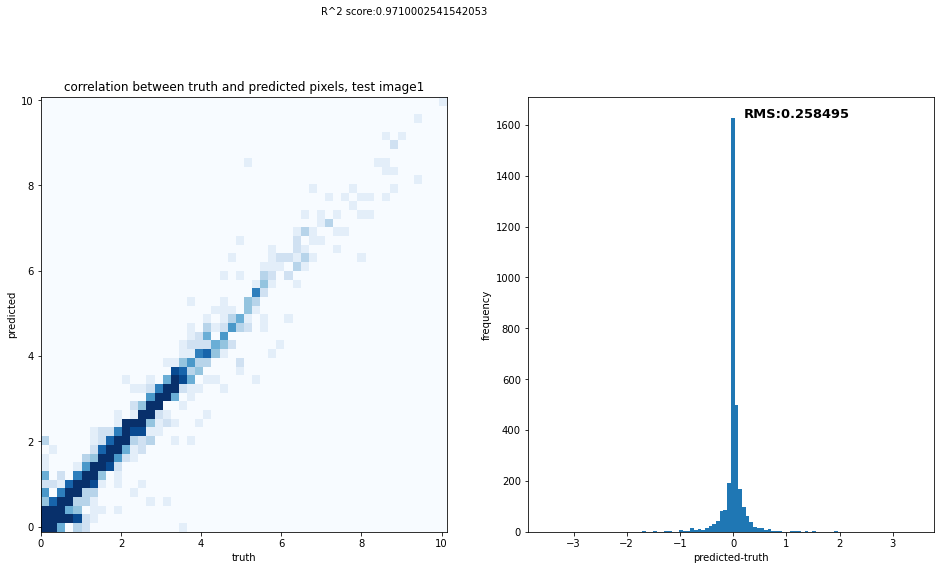

In [84]:

import math
network.eval()


with torch.no_grad():
    for count, (data, target) in enumerate(test_loader):
        inputs = data[count].resize(1, 4, 56, 56)
        
        output = processor(torch.stack(network(inputs)).resize(1, 3, 56, 56)).reshape(56, 56)
        target = target[count]
        break
        
   # plt.imshow(output)
   # plt.title('predicted image')
    #plt.show()
    #plt.imshow(target)
    #plt.title('truth image')
    #plt.show()

fig = plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
plt.hist2d(target.numpy().flatten(),output.numpy().flatten(), bins = (50,50), vmax = 10, cmap = "Blues")
plt.xlabel("truth")
plt.ylabel("predicted")
plt.text(7, 12,f"R^2 score:{r2_score(output, target)}")
plt.title(f"correlation between truth and predicted pixels, test image{1}")



plt.subplot(1,2,2)
error = output.numpy().flatten() - target.numpy().flatten()
h, xedges, yedges = plt.hist(error, bins = 100)
rms = Rms(error)






plt.text(0.2,max(h),f"RMS:{rms:.6f}", font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 13})
#plt.text(0.2,max(h)-80,f"std:{np.std(error)}")
plt.xlabel("predicted-truth")
plt.ylabel("frequency")
plt.show()


In [36]:
writer = SummaryWriter('runs/nested_U-net_v1')


dummy_input = torch.randn(1, 4, 56, 56)

model = Nested_U_net(4, 1)

writer.add_graph(model, dummy_input)



writer.close()

/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_trace.py:1074: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


In [37]:
!tensorboard --logdir=runs

/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jenson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
